### Data Loading




In [49]:
#title Load Data Cifar10

import torch
import torchvision
import time
import random
import seaborn as sns

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Load and transform data
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=False)

# preload

train_data = [ sample for sample in trainloader ]
test_data  = [ sample for sample in testloader  ]

Files already downloaded and verified
Files already downloaded and verified


### Data Visualization

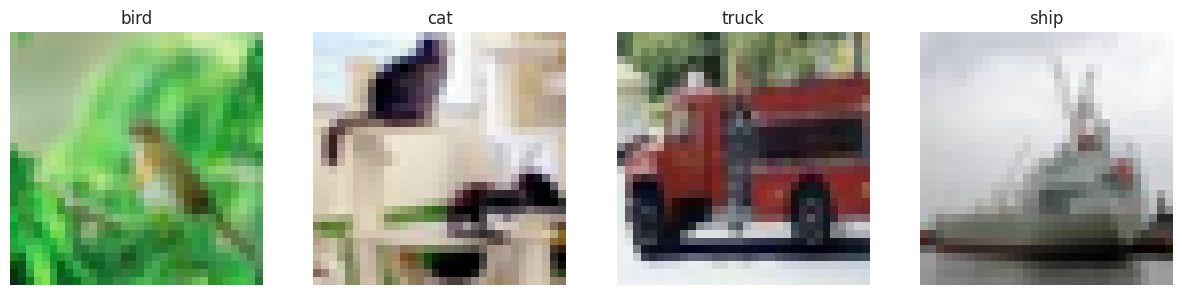

In [50]:
# visualize data with labels

import matplotlib.pyplot as plt
import numpy as np

# get classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0)).astype(np.float32)
# get some random training images

dataiter = iter(trainloader)
images, labels = next(dataiter)

fig, axs = plt.subplots(1, 4, figsize=(15, 5))

for image, i in zip(images, range(4)):

    # show images
    image = imshow(image)
    axs[i].imshow(image)
    axs[i].set_title(classes[labels[i]])
    axs[i].axis('off')


In [51]:
# Classification model ResNet18 based

import torch.nn as nn

class ClassificationNet(nn.Module):

    def __init__(self, features=16, num_layers=4, img_size=32):
        super(ClassificationNet, self).__init__()

        # define layers
        layers = []

        down_factor = 1

        # first layer
        layers.append(nn.Conv2d(3, features, kernel_size=3, stride=1, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(features))

        # hidden layers
        for _ in range(num_layers):
            layers.append(nn.Conv2d(features, features, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(features))
            layers.append(nn.ReLU(inplace=True))
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            down_factor *= 2

        layers.append(nn.Flatten())

        final_size = int(img_size / down_factor)

        # output layer
        layers.append(nn.Linear(features * final_size * final_size, 10))
        layers.append(nn.Softmax(dim=1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [52]:
model = ClassificationNet()

In [53]:
criterion = nn.CrossEntropyLoss()

In [54]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [55]:
class AverageMeter(object):
  '''A handy class from the PyTorch ImageNet tutorial'''
  def __init__(self):
    self.reset()

  def __str__(self):
    return f"{self.avg}"

  def reset(self):
    self.vals, self.avg, self.sum, self.count = [], 0, 0, 0

  def update(self, val, n=1):
    self.vals.append(val)
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count




In [56]:
# top1 accuracy
def accuracy(output, target, topk=(1,)):
    '''Computes the accuracy over the k top predictions for the specified values of k'''
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()

        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))

        return res

In [57]:

def validate(test_loader, model, criterion):
    model.eval()

    batch_time, data_time, losses, top1 = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()

    for i, (image, label) in enumerate(test_loader):

        data_time.update(time.time() - end)

        image, label = image.to(device), label.to(device)

        output = model(image)
        loss = criterion(output, label)
        losses.update(loss.item(), image.size(0))

        # measure accuracy and record loss
        prec1 = accuracy(output.data, label, topk=(1,))[0].item()
        top1.update(prec1, image.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

    print(f'Test: \tTime {batch_time.vals[-1]:.3f} ({batch_time.avg:.3f})\t'
        f'Data {data_time.vals[-1]:.3f} ({data_time.avg:.3f})\t'
        f'Loss {losses.vals[-1]:.4f} ({losses.avg:.4f})\t'
        f'Accuracy {top1.vals[-1]:.3f} ({top1.avg:.3f})')

    return losses.avg, top1.avg

In [58]:
def train(train_loader, model, criterion, epoch):
    random.shuffle(train_loader)

    print('Starting training epoch {}'.format(epoch))
    model.train()
    scaler = torch.cuda.amp.GradScaler()

    batch_time, data_time, losses, top1 = AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()

    for i, (image, label) in enumerate(train_loader):
        optimizer.zero_grad()

        image, label = image.to(device), label.to(device)

        data_time.update(time.time() - end)
       
        with torch.cuda.amp.autocast(dtype=torch.float16):
          output = model(image)
          loss = criterion(output, label)

        losses.update(loss.item(), image.size(0))

        # measure accuracy and record loss
        prec1 = accuracy(output.data, label, topk=(1,))[0].item()

        top1.update(prec1, image.size(0))


        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 50 == 0:

            print(f'Epoch: [{epoch}][{i}/{len(train_loader)}]\t'
                f'Time {batch_time.vals[-1]:.3f} ({batch_time.avg:.3f})\t'
                f'Data {data_time.vals[-1]:.3f} ({data_time.avg:.3f})\t'
                f'Loss {losses.vals[-1]:.4f} ({losses.avg:.4f})\t'
                f'Accuracy {top1.vals[-1]:.3f} ({top1.avg:.3f})')


    return losses.vals, top1.vals

In [59]:
# Move model and loss function to GPU

criterion = criterion.to(device)
model = model.to(device)

In [60]:
# train model for 1000 epochs

epochs = 3
history = {
    'loss': [],
    'acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(epochs):

    losses, acc = train(train_data, model, criterion, epoch)

    with torch.no_grad():
        val_loss, val_acc = validate(test_data, model, criterion)

    history['loss'].extend(losses)
    history['acc'].extend(acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)


Starting training epoch 0


/home/codespace/.local/lib/python3.10/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
/home/codespace/.local/lib/python3.10/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch: [0][0/98]	Time 0.353 (0.353)	Data 0.000 (0.000)	Loss 2.3041 (2.3041)	Accuracy 9.961 (9.961)
Epoch: [0][50/98]	Time 0.232 (0.251)	Data 0.000 (0.000)	Loss 2.1327 (2.2072)	Accuracy 36.523 (26.874)
Test: 	Time 0.130 (0.181)	Data 0.000 (0.000)	Loss 2.0256 (2.0420)	Accuracy 47.959 (45.620)
Starting training epoch 1
Epoch: [1][0/98]	Time 0.227 (0.227)	Data 0.000 (0.000)	Loss 2.0169 (2.0169)	Accuracy 51.758 (51.758)
Epoch: [1][50/98]	Time 0.226 (0.227)	Data 0.000 (0.000)	Loss 1.9851 (1.9905)	Accuracy 50.586 (51.172)
Test: 	Time 0.139 (0.183)	Data 0.000 (0.000)	Loss 1.9252 (1.9336)	Accuracy 55.485 (55.560)
Starting training epoch 2
Epoch: [2][0/98]	Time 0.226 (0.226)	Data 0.000 (0.000)	Loss 1.9150 (1.9150)	Accuracy 57.617 (57.617)
Epoch: [2][50/98]	Time 0.229 (0.230)	Data 0.000 (0.000)	Loss 1.8941 (1.9060)	Accuracy 58.008 (58.211)
Test: 	Time 0.138 (0.185)	Data 0.000 (0.000)	Loss 1.8927 (1.8879)	Accuracy 59.311 (59.790)


In [61]:
# this is just for test
# ignore this cell

epochs = 3
history_2 = {
    'loss': [],
    'acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(epochs):

    losses, acc = train(train_data, model, criterion, epoch)

    with torch.no_grad():
        val_loss, val_acc = validate(test_data, model, criterion)

    history_2['loss'].extend(losses)
    history_2['acc'].extend(acc)
    history_2['val_loss'].append(val_loss)
    history_2['val_acc'].append(val_acc)


Starting training epoch 0


Epoch: [0][0/98]	Time 0.228 (0.228)	Data 0.000 (0.000)	Loss 1.8770 (1.8770)	Accuracy 61.523 (61.523)
Epoch: [0][50/98]	Time 0.226 (0.230)	Data 0.000 (0.000)	Loss 1.8450 (1.8610)	Accuracy 63.281 (62.538)
Test: 	Time 0.137 (0.182)	Data 0.000 (0.000)	Loss 1.8618 (1.8561)	Accuracy 61.607 (62.550)
Starting training epoch 1
Epoch: [1][0/98]	Time 0.228 (0.228)	Data 0.000 (0.000)	Loss 1.8238 (1.8238)	Accuracy 65.430 (65.430)
Epoch: [1][50/98]	Time 0.304 (0.230)	Data 0.000 (0.000)	Loss 1.8578 (1.8354)	Accuracy 63.672 (64.794)
Test: 	Time 0.139 (0.183)	Data 0.000 (0.000)	Loss 1.8470 (1.8496)	Accuracy 62.883 (62.480)
Starting training epoch 2
Epoch: [2][0/98]	Time 0.224 (0.224)	Data 0.000 (0.000)	Loss 1.8202 (1.8202)	Accuracy 66.797 (66.797)
Epoch: [2][50/98]	Time 0.228 (0.237)	Data 0.000 (0.000)	Loss 1.7925 (1.8173)	Accuracy 69.922 (66.288)
Test: 	Time 0.138 (0.179)	Data 0.000 (0.000)	Loss 1.8439 (1.8336)	Accuracy 63.010 (64.320)


In [62]:
def acc_barplot(history):
    """
    this function plots the training and testing history for n models in a barplot
    
    Parameters:
    -----------
    history: numpy array
        list of training history for n models, each model is a dictionary with keys 'loss', 'acc', 'val_loss', 'val_acc'
        each model must have the same number of epochs and metrics
    """

    models = [ f'Model {i}' for i in range(len(history)) ]

    accs = [ model['acc'][-1] for model in history ]
    val_accs = [ model['val_acc'][-1] for model in history ]
    acc = accs + val_accs

    hue_labels = ['train'] * len(accs) + ['test'] * len(val_accs)

    sns.set(style="whitegrid")
    sns.barplot(x=models * 2, y=acc, hue=hue_labels)

    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of Models (Train vs Test)')

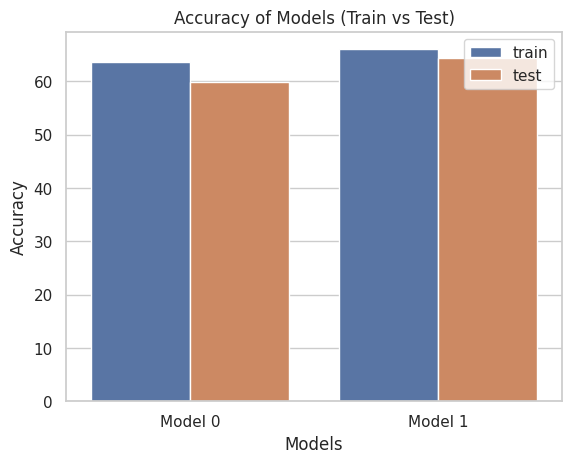

In [63]:
acc_barplot(np.array([history,history_2]))

In [66]:
def batch_lineplot(history):
    """
    This function plots the training and testing history for n models

    Parameters:
    ----------
    history: numpy array
        list of training history for n models, each model is a dictionary with keys 'loss', 'acc', 'val_loss', 'val_acc'
        each model must have the same number of epochs and metrics

    """

    accs = [ model['acc'] for model in history ]
    val_accs = [ model['val_acc'] for model in history ]

    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 6))
    for i,acc in enumerate(accs):
        sns.lineplot(x=range(len(acc)), y=acc, label=f'Model {i}')

    plt.gca().set_prop_cycle(None) # restar color cycle

    for i, val_acc in enumerate(val_accs):
        sns.lineplot(x=range( len(accs[0])//(len(val_acc)), len(accs[0])+1, len(accs[0])//(len(val_acc))), y=val_acc, label=f'Model {i} (test)'
                     , marker='o', markersize=7, linestyle='--')
        
    plt.xlabel('Batch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of Models (Train vs Test)')

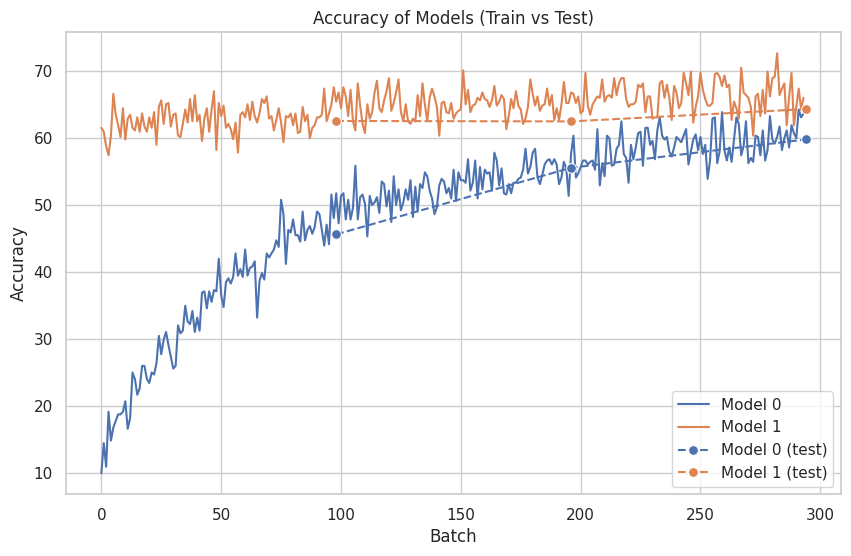

In [67]:
batch_lineplot(np.array([history,history_2]))